# Imports

In [2]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# sys.path.insert(1, '/kaggle/input/utiletet1')
# from util import *
from Config.util import *

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Dataset

In [5]:
data = pd.read_csv('Datasets/happiness.csv')
data.head()

,Country,Region,Rank 2019,Score 2019,GDP 2019,Family 2019,Life Expectancy 2019,Freedom 2019,Trust 2019,Generosity 2019
0,Afghanistan,Southern Asia,154,3.203,0.350,0.517,0.361,0.000,0.025,0.158
1,Albania,Central and Eastern Europe,107,4.719,0.947,0.848,0.874,0.383,0.027,0.178
2,Algeria,Middle East and Northern Africa,88,5.211,1.002,1.160,0.785,0.086,0.114,0.073
3,Argentina,Latin America and Caribbean,47,6.086,1.092,1.432,0.881,0.471,0.050,0.066
4,Armenia,Central and Eastern Europe,116,4.559,0.850,1.055,0.815,0.283,0.064,0.095


In [6]:
target_col_name = 'Score 2019'

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Country               156 non-null    object 
 1   Region                156 non-null    object 
 2   Rank 2019             156 non-null    int64  
 3   Score 2019            156 non-null    float64
 4   GDP 2019              156 non-null    float64
 5   Family 2019           156 non-null    float64
 6   Life Expectancy 2019  156 non-null    float64
 7   Freedom 2019          156 non-null    float64
 8   Trust 2019            156 non-null    float64
 9   Generosity 2019       156 non-null    float64
dtypes: float64(7), int64(1), object(2)
memory usage: 12.3+ KB


In [8]:
data['Region'].unique()

array(['Southern Asia', 'Central and Eastern Europe',
       'Middle East and Northern Africa', 'Latin America and Caribbean',
       'Australia and New Zealand', 'Western Europe',
       'Sub-Saharan Africa', 'Southeastern Asia', 'North America',
       'Eastern Asia'], dtype=object)

In [9]:
data['Country'].nunique()

156

In [10]:
data.drop(columns=['Country'], inplace=True)

In [11]:
object_cols = data.select_dtypes(include='object').columns.to_list()
for col in object_cols:
    print(f"{col} is{'' if is_consumption(data, col, target_col_name, 0.5) else ' not'} a consumption column")

Region is not a consumption column


In [12]:
data = pd.get_dummies(data, columns=object_cols)
data.head()

,Rank 2019,Score 2019,GDP 2019,Family 2019,Life Expectancy 2019,Freedom 2019,Trust 2019,Generosity 2019,Region_Australia and New Zealand,Region_Central and Eastern Europe,Region_Eastern Asia,Region_Latin America and Caribbean,Region_Middle East and Northern Africa,Region_North America,Region_Southeastern Asia,Region_Southern Asia,Region_Sub-Saharan Africa,Region_Western Europe
0,154,3.203,0.350,0.517,0.361,0.000,0.025,0.158,False,False,False,False,False,False,False,True,False,False
1,107,4.719,0.947,0.848,0.874,0.383,0.027,0.178,False,True,False,False,False,False,False,False,False,False
2,88,5.211,1.002,1.160,0.785,0.086,0.114,0.073,False,False,False,False,True,False,False,False,False,False
3,47,6.086,1.092,1.432,0.881,0.471,0.050,0.066,False,False,False,True,False,False,False,False,False,False
4,116,4.559,0.850,1.055,0.815,0.283,0.064,0.095,False,True,False,False,False,False,False,False,False,False


# PCA

In [13]:
pca = PCA(n_components=1)
pca_result = pca.fit_transform(data.drop(columns=[target_col_name]))
data['PCA'] = pca_result[:, 0]

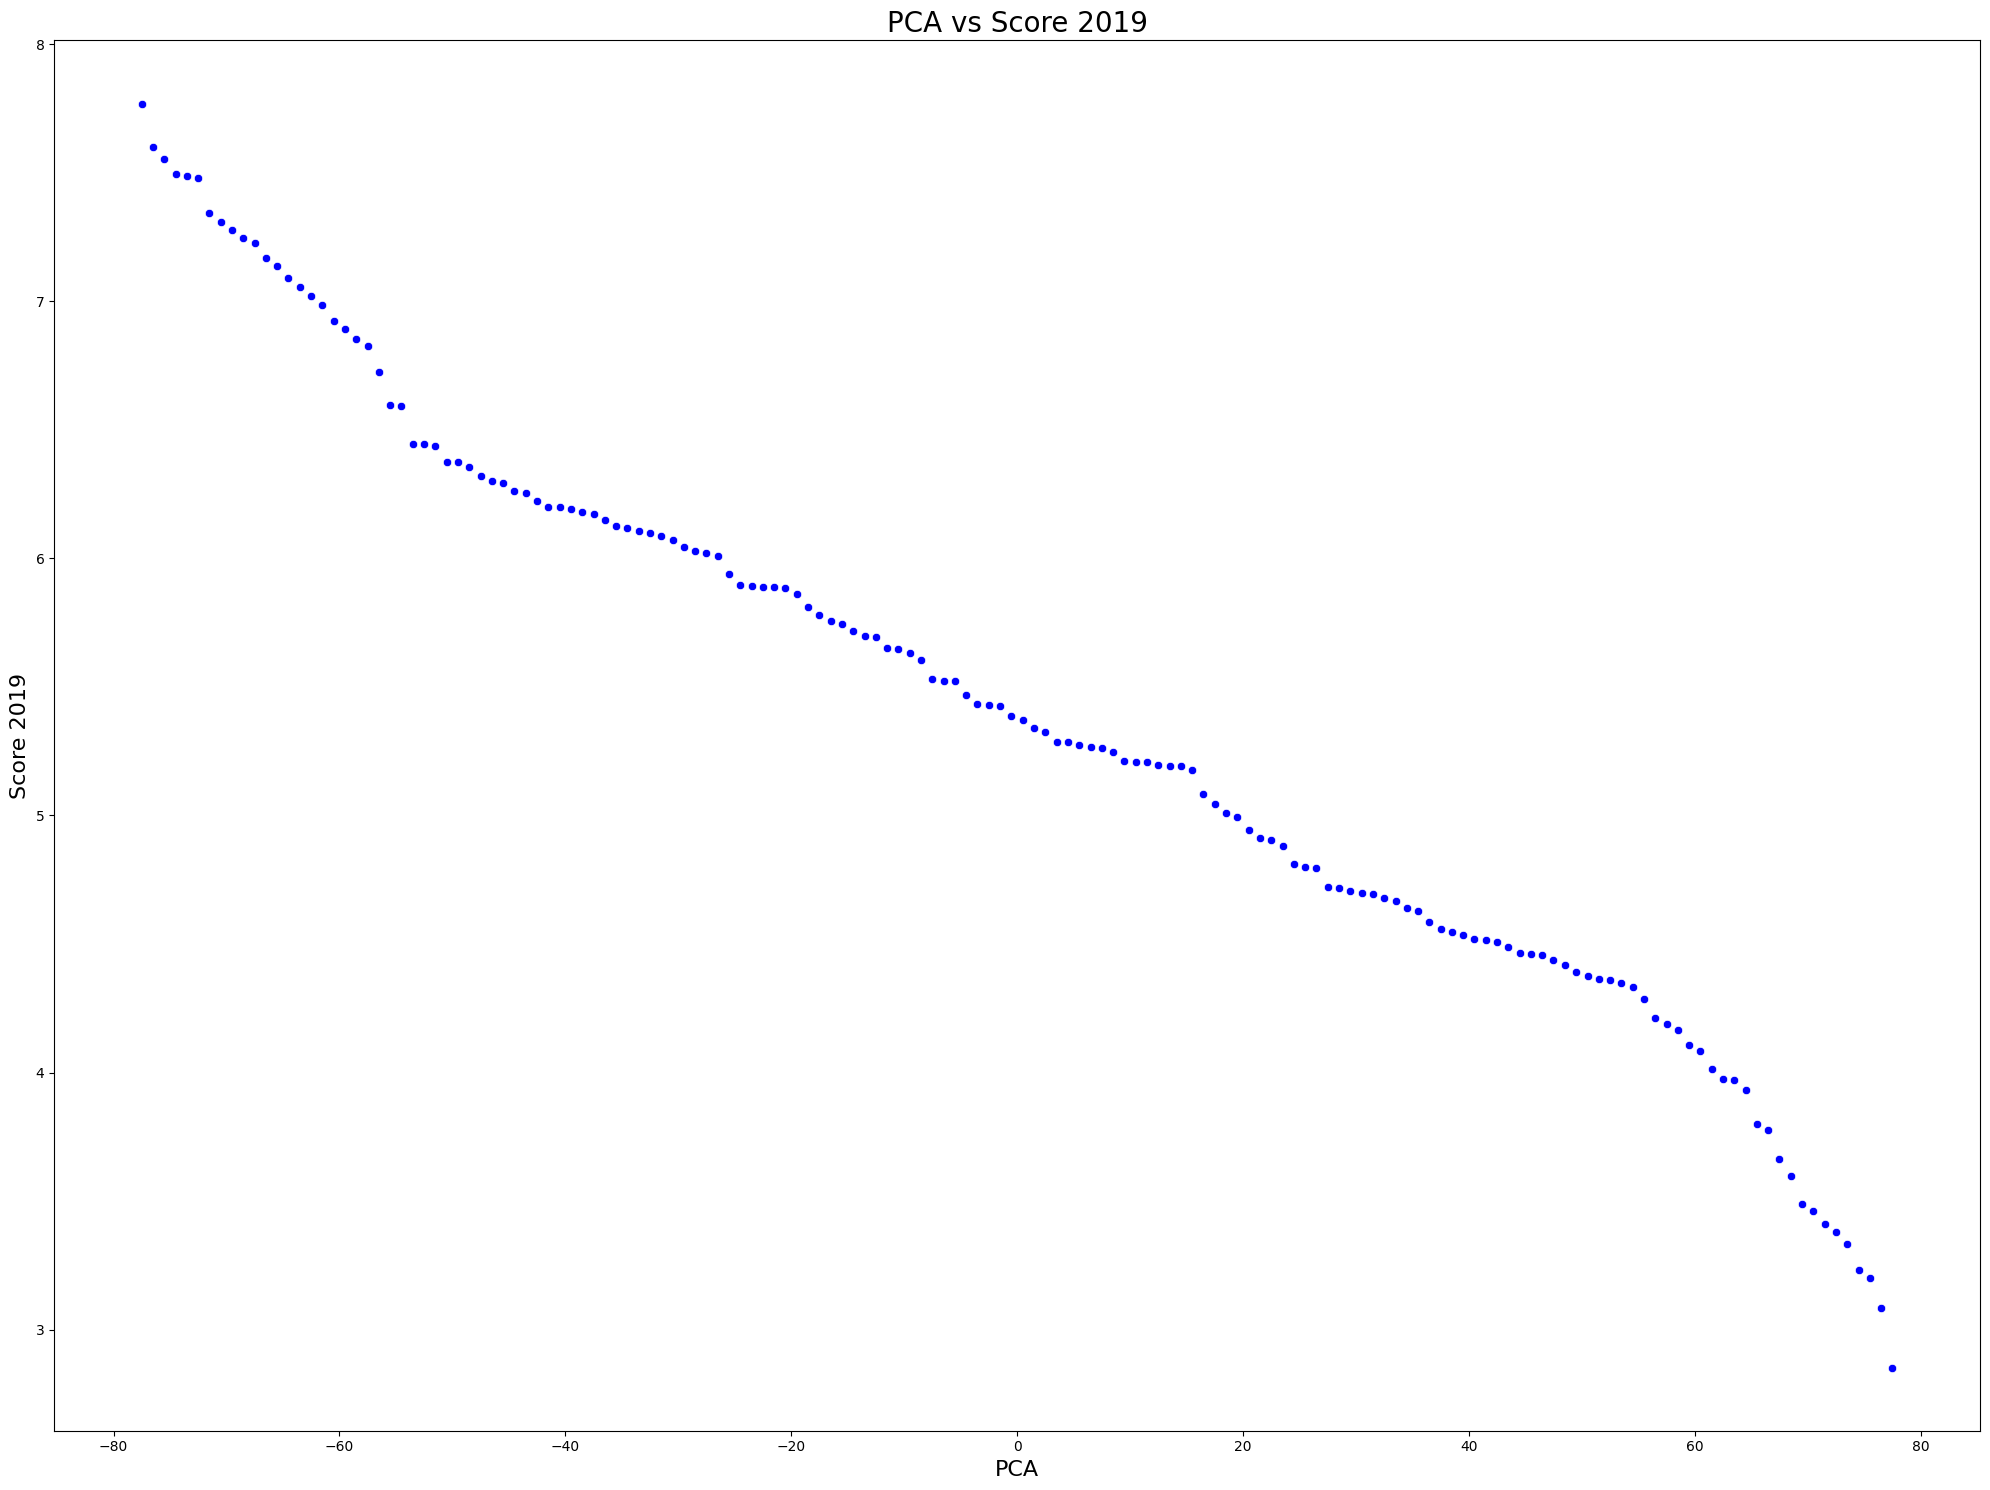

In [14]:
fig, axe = plt.subplots(figsize=(20, 15))

sns.scatterplot(x='PCA', y=target_col_name, data=data, ax=axe, color='b')
axe.set_title(f'PCA vs {target_col_name}', fontsize=20)
axe.set_xlabel('PCA', fontsize=16)
axe.set_ylabel(target_col_name, fontsize=16)

plt.tight_layout()
plt.show()

In [15]:
data['PCA'] = data['PCA'].max() - data['PCA']

# Training

In [16]:
test_pairs = generate_random_pairs(data, 20000)
test_df = create_pair_df(data, test_pairs, target_col_name)

In [17]:
tree_depth = int(np.round(np.sqrt(len(data.columns))))

In [18]:
mf1 = train_evaluate_repeat(generate_random_pairs, data, num_samples=100000, depth=tree_depth, test_df=test_df, use_bradley=True, exp=True, add_noise=False, noise=0.1, label_col=target_col_name, repeats=1)

100%|██████████| 1/1 [00:28<00:00, 28.71s/it]

Mean Accuracy: 0.9374
Mean Precision: 0.9386669343505321
Mean Recall: 0.9358486789431545
Mean F1 Score: 0.93725568808259


In [18]:
var, residuals = calculate_pca_var(data, target_col_name)
print(var)

3947.10690368967


In [19]:
# Calculating the number of pairs
max_pairs = len(data) * 50
alpha = 1e-3

num_pairs = int(max_pairs / (1 + alpha * var))
print(num_pairs)

1576


In [20]:
pretrain_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': tree_depth
}
pretrained_model = pretrain_model_with_residuals(df=data, n_samples=num_pairs, pretrain_params=pretrain_params, target_col=target_col_name, residuals=residuals)

In [21]:
step = 50
num_samples = 800
repeats = 40

f1_scores_UB_repeats = []
f1_scores_UP_repeats = []
f1_scores_RB_repeats = []

# Create a for loop from n to num_samples with a step of n
for _ in range(repeats):
    f1_scores_UB, f1_scores_UP, f1_scores_RB = compare_three_methods(
        df=data,
        test_df=test_df,
        pretrain_params=pretrain_params,
        pretrained_model=pretrained_model,
        target_col=target_col_name,
        use_bradley=True,
        exp=True,
        add_noise=False,
        total_pairs=num_samples,
        batch_size=step,
    )
    f1_scores_UB_repeats.append(f1_scores_UB)
    f1_scores_UP_repeats.append(f1_scores_UP)
    f1_scores_RB_repeats.append(f1_scores_RB)

# Compute the average F1 scores across repeats
average_f1_scores_UB = np.mean(f1_scores_UB_repeats, axis=0)
average_f1_scores_UP = np.mean(f1_scores_UP_repeats, axis=0)
average_f1_scores_RB = np.mean(f1_scores_RB_repeats, axis=0)

Blank model with random pairs: 100%|██████████| 16/16 [00:04<00:00,  3.99it/s]


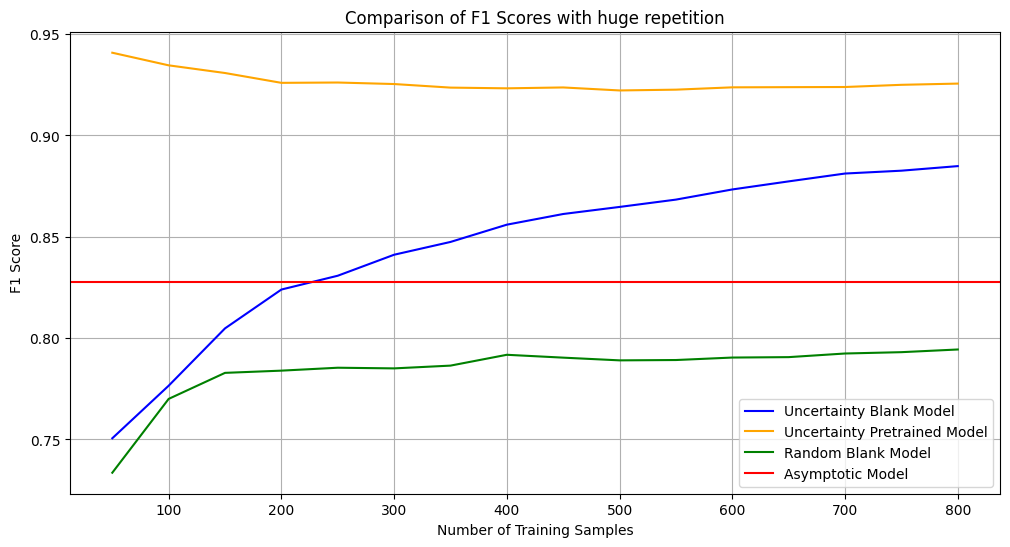

In [22]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(step, num_samples+1, step), average_f1_scores_UB, label='Uncertainty Blank Model', color='blue')
plt.plot(range(step, num_samples+1, step), average_f1_scores_UP, label='Uncertainty Pretrained Model', color='orange')
plt.plot(range(step, num_samples+1, step), average_f1_scores_RB, label='Random Blank Model', color='green')
plt.axhline(y = mf1, color = 'r', linestyle = '-', label='Asymptotic Model')
plt.xlabel('Number of Training Samples')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores with huge repetition')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
step = 50
num_samples = 10000
repeats = 1

f1_scores_UB_repeats2 = []
f1_scores_UP_repeats2 = []
f1_scores_RB_repeats2 = []

# Create a for loop from n to num_samples with a step of n
for _ in range(repeats):
    f1_scores_UB, f1_scores_UP, f1_scores_RB = compare_three_methods(
        df=data,
        test_df=test_df,
        pretrain_params=pretrain_params,
        pretrained_model=pretrained_model,
        target_col=target_col_name,
        use_bradley=True,
        exp=True,
        add_noise=False,
        total_pairs=num_samples,
        batch_size=step,
    )
    f1_scores_UB_repeats2.append(f1_scores_UB)
    f1_scores_UP_repeats2.append(f1_scores_UP)
    f1_scores_RB_repeats2.append(f1_scores_RB)

# Compute the average F1 scores across repeats
average_f1_scores_UB2 = np.mean(f1_scores_UB_repeats2, axis=0)
average_f1_scores_UP2 = np.mean(f1_scores_UP_repeats2, axis=0)
average_f1_scores_RB2 = np.mean(f1_scores_RB_repeats2, axis=0)

Blank model with random pairs: 100%|██████████| 200/200 [01:08<00:00,  2.91it/s]


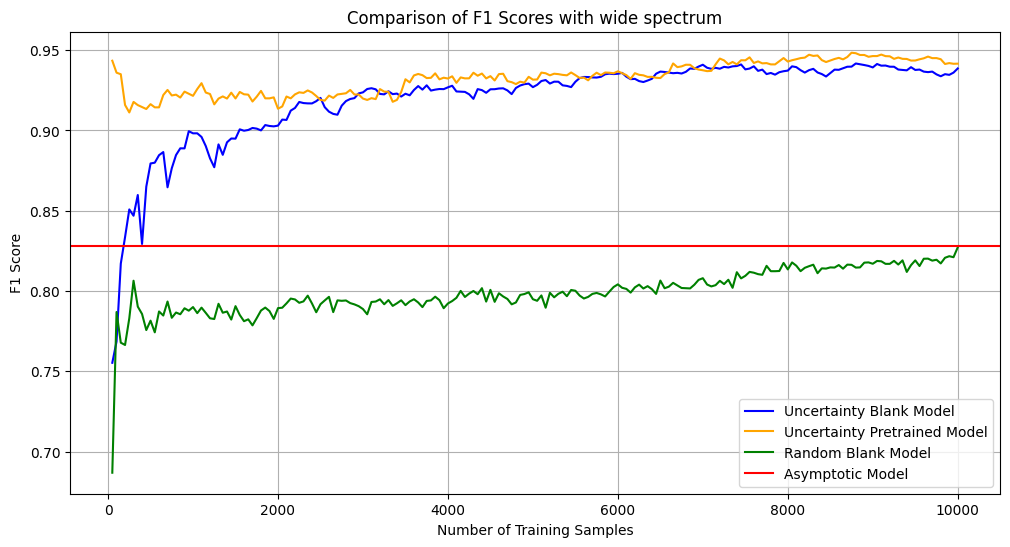

In [24]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(step, num_samples+1, step), average_f1_scores_UB2, label='Uncertainty Blank Model', color='blue')
plt.plot(range(step, num_samples+1, step), average_f1_scores_UP2, label='Uncertainty Pretrained Model', color='orange')
plt.plot(range(step, num_samples+1, step), average_f1_scores_RB2, label='Random Blank Model', color='green')
plt.axhline(y = mf1, color = 'r', linestyle = '-', label='Asymptotic Model')
plt.xlabel('Number of Training Samples')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores with wide spectrum')
plt.legend()
plt.grid(True)
plt.show()